   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000       

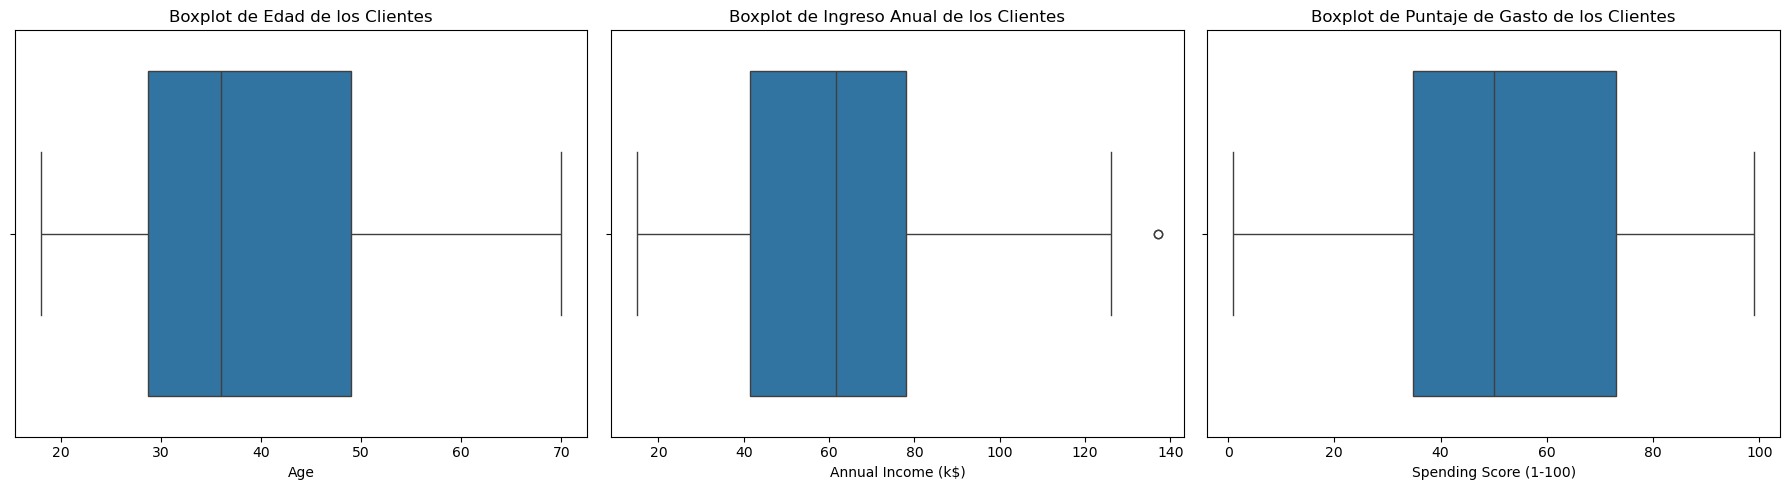

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Características seleccionadas: Index(['Gender', 'Age', 'Annual Income (k$)'], dtype='object')


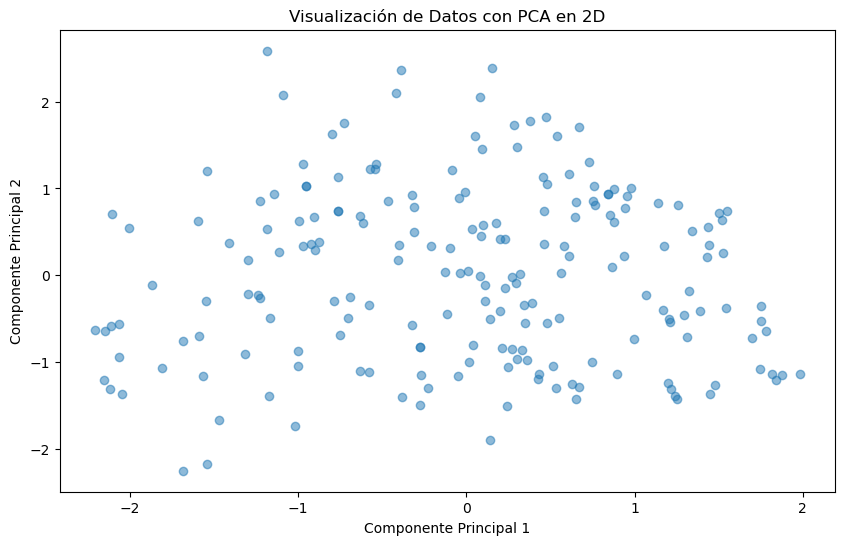

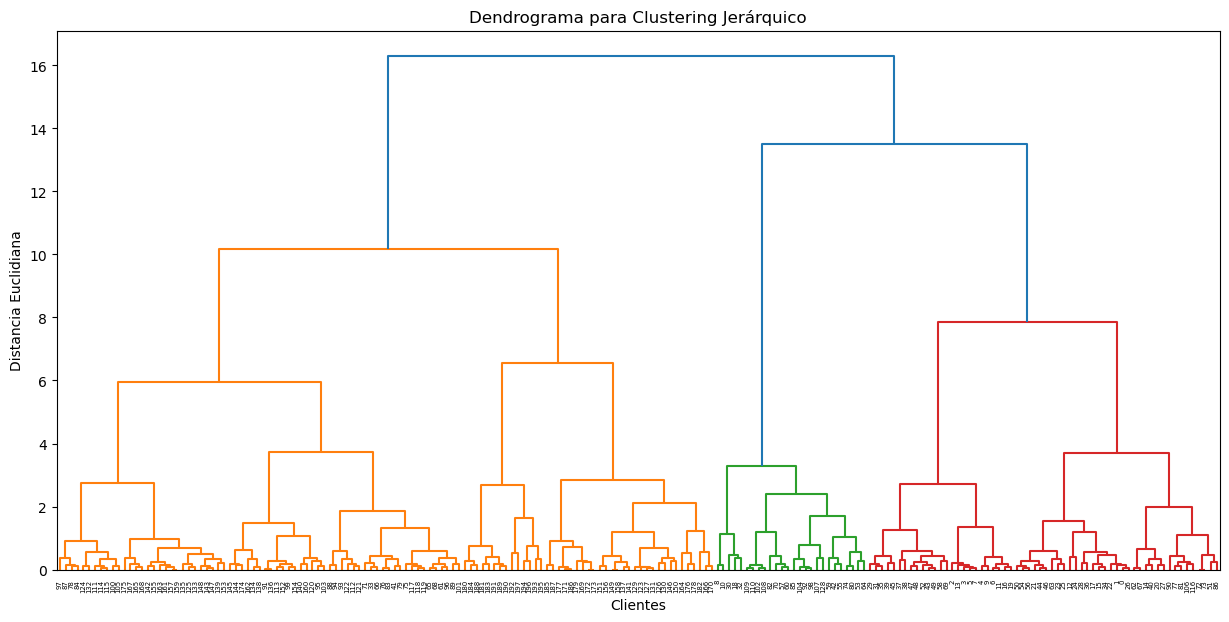

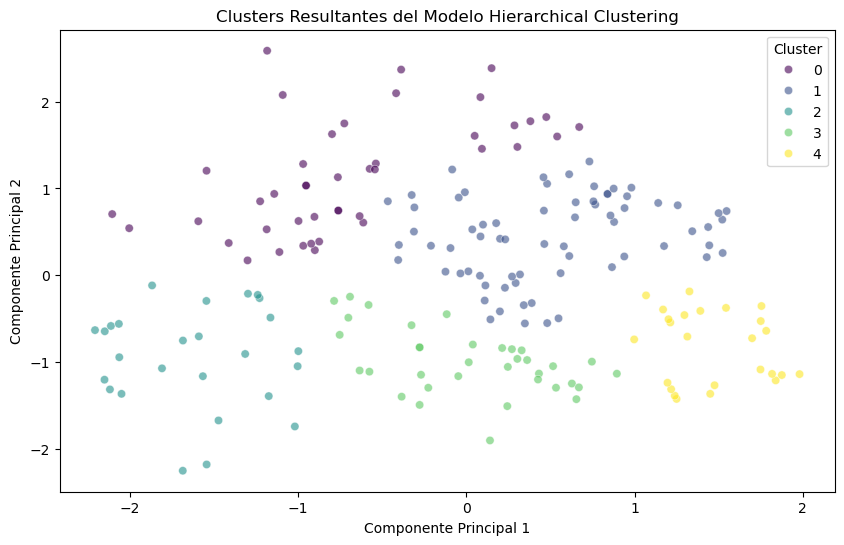

Coeficiente de Silhouette: 0.3443435403401504
Índice de Calinski-Harabasz: 142.81466228229687
Índice de Davies-Bouldin: 0.8797557636576542
           Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                 
0        0.302326  38.558140           91.325581               51.279070
1        0.753623  32.318841           66.768116               51.681159
2        0.000000  58.846154           48.692308               39.846154
3        0.628571  45.542857           37.114286               46.514286
4        1.000000  27.840000           29.560000               60.160000

Se realizaron las siguientes mejoras:
1. Se ajustaron los hiperparámetros del modelo Agglomerative Clustering con el método 'ward'.
2. Se añadió la visualización del dendrograma para la identificación jerárquica de clusters.
3. Se utilizó el análisis de outliers utilizando el rango intercuartílico (IQR).
4. Se utilizó SelectKBest para la selección

In [3]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import warnings

# Configuración para evitar múltiples advertencias
warnings.filterwarnings('ignore')

# Carga del dataset
data = pd.read_csv('Mall_Customers.csv')

# Mostrar una vista previa de los datos para entender la estructura inicial
print(data.head())

# Descripción estadística de las variables para entender tendencias y distribuciones
print(data.describe())

# Información general para identificar valores nulos y tipos de datos
print(data.info())

# Visualización de la distribución de las variables relevantes
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x=data['Age'])
plt.title('Boxplot de Edad de los Clientes')

plt.subplot(1, 3, 2)
sns.boxplot(x=data['Annual Income (k$)'])
plt.title('Boxplot de Ingreso Anual de los Clientes')

plt.subplot(1, 3, 3)
sns.boxplot(x=data['Spending Score (1-100)'])
plt.title('Boxplot de Puntaje de Gasto de los Clientes')

plt.tight_layout()
plt.show()

# Eliminación de la columna 'CustomerID' ya que no contribuye al análisis
data = data.drop(columns=['CustomerID'])

# Codificación de 'Gender' en valores numéricos para facilitar el análisis
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

# Comprobación de valores nulos en el dataset
print(data.isnull().sum())

# Eliminación de outliers usando el rango intercuartílico (IQR) para mejorar la calidad del clustering
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Selección de características relevantes con SelectKBest
X = data.drop(columns=['Spending Score (1-100)'])
y = data['Spending Score (1-100)']
selector = SelectKBest(score_func=f_classif, k=3)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Características seleccionadas: {selected_features}")

# Escalado de las variables numéricas
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_new)

# Reducción de dimensionalidad con PCA a 2 componentes principales para facilitar la visualización
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Visualización de los resultados de PCA en 2D
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Datos con PCA en 2D')
plt.show()

# Generación de la matriz de linkage para la visualización del dendrograma
linkage_matrix = linkage(data_pca, method='ward')

# Visualización del dendrograma
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma para Clustering Jerárquico')
plt.xlabel('Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()

# Definición del número óptimo de clusters según el dendrograma
optimal_k = 5

# Entrenamiento del modelo Agglomerative Clustering con los parámetros seleccionados
agg_cluster = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
labels = agg_cluster.fit_predict(data_pca)

# Adición de las etiquetas de clusters al dataframe original para su posterior análisis
data['Cluster'] = labels

# Visualización de los clusters resultantes en el espacio reducido por PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis', alpha=0.6)
plt.title('Clusters Resultantes del Modelo Hierarchical Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

# Cálculo de métricas de evaluación para medir la calidad del clustering
silhouette_avg = silhouette_score(data_pca, labels)
calinski_harabasz = calinski_harabasz_score(data_pca, labels)
davies_bouldin = davies_bouldin_score(data_pca, labels)

print(f"Coeficiente de Silhouette: {silhouette_avg}")
print(f"Índice de Calinski-Harabasz: {calinski_harabasz}")
print(f"Índice de Davies-Bouldin: {davies_bouldin}")

# Análisis descriptivo de cada cluster para interpretar las características generales de los grupos
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

# Resumen de mejoras aplicadas
print("\nSe realizaron las siguientes mejoras:")
print("1. Se ajustaron los hiperparámetros del modelo Agglomerative Clustering con el método 'ward'.")
print("2. Se añadió la visualización del dendrograma para la identificación jerárquica de clusters.")
print("3. Se utilizó el análisis de outliers utilizando el rango intercuartílico (IQR).")
print("4. Se utilizó SelectKBest para la selección de características relevantes.")
print("5. Se evaluó el modelo con métricas como Silhouette, Calinski-Harabasz, y Davies-Bouldin.")
